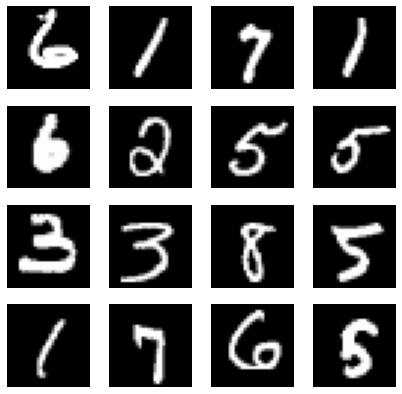

In [20]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import warnings

import pandas as pd

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# vae for mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from matplotlib import pyplot as plt
from carla.recourse_methods.processing import  merge_default_parameters
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Load mnist data while reshaping from (28,28) to 784
train_data = datasets.MNIST(root='./data', train=True, download
                            =True,
                            # Reshape from (28,28) to (784)
                            transform=transforms.ToTensor())

# Reshape the data to (batch_size, 784)
train_data = train_data.train_data.view(train_data.train_data.size()[0],28*28)

# Transform train_data to FloatTensor
train_data = train_data.type(torch.FloatTensor)

# Define dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)



# Visualize the data
def show_mnist(images):
    images = images.numpy()
    axes = plt.figure(figsize=(7, 7)).subplots(4, 4)
    for i in range(16):
        axes[i // 4, i % 4].imshow(images[i].reshape(28,28), cmap='gray')
        # Plot the title with little offset from the image
        axes[i // 4, i % 4].axis('off')
    plt.show()

# # Get the first batch of data
data = next(iter(train_loader))
show_mnist(data)

# Build the VAE
class VAE(nn.Module):
    _DEAFULT_PARAMS = {
        'input_dim': 784,
        'layers': [512, 128],
        'latent_dim': 32,
        'hidden_activation': 'relu',
        'dropout': 0.2,
        'batch_norm': True,
        'batch_size': 64,
        'epochs': 100,
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'cuda': True,
        'verbose': True,
        'train': True,
        'save_dir': './models/',
    }
    def __init__(self, params):
        super(VAE, self).__init__()
        self.params = merge_default_parameters(params, self._DEAFULT_PARAMS)
        # Define the encoder
        self._encoder, self._mu_enc, self._log_var_enc = self.define_encoder()
        # Define the decoder
        self._mu_dec = self.define_decoder()
        # Define the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'],
                                    weight_decay=self.params['weight_decay'])
        # Define the loss function
        self.criterion = nn.MSELoss()
        # Define the cuda
        if self.params['cuda']:
            self.cuda()
        # Check if train is true
        if self.params['train']:
            self.fit_model()
        else:
            # Load the model from save_dir by searching for the path containing '_epoch_best_model.pth'
            # Search for the path containing '_epoch_best_model.pth'
            path = glob(os.path.join(self.params['save_dir'], '*_epoch_best_model.pth'))
            # Assert if path is empty list
            assert len(path) == 1, 'There should be only one file containing the best model, eith no checkpoint or more than one checkpoint'
            path = path[0]
            # Load the model
            self.load_model(path)
    
    def load_model(self, path):
        # Load the model
        self.load_state_dict(torch.load(path))
        # Print the model
        print('Model loaded from {}'.format(path))



    def define_data(self):
        # Load mnist data while reshaping from (28,28) to 784
        train_data = datasets.MNIST(root='./data', train=True, download
                                    =True,
                                    # Reshape from (28,28) to (784)
                                    transform=transforms.ToTensor())

        # Reshape the data to (batch_size, 784)
        train_data = train_data.train_data.view(train_data.train_data.size()[0],28*28)

        # Transform train_data to FloatTensor
        train_data = train_data.type(torch.FloatTensor)

        # Define dataloader
        return torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

    def forward(self, x):
        # Encode the input
        mu, log_var = self.encode(x)
        # Sample from the latent space
        z = self.sample(mu, log_var)
        # Decode the input
        x_hat = self.decode(z)
        # Return the mean and the log_var
        return x_hat, mu, log_var


    # Define plot loss
    def plot_loss(self):
        # Using self.loss_list = {'Steps':[],'Loss':[]}
        steps = self.loss_list['Steps']
        loss = self.loss_list['Loss']
        # Plot the loss
        plt.plot(steps, loss)
        # Set the title and labels
        plt.title('Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        # Show the plot
        plt.show()

    
    # Define training function
    def fit_model(self):
        # Create save_dir if it doesn't exist
        if not os.path.exists(self.params['save_dir']):
            os.makedirs(self.params['save_dir'])
        # Set the model to train mode
        self.train()
        # Define loss list for visualization
        self.loss_list = {'Steps':[],'Loss':[]}
        # Define Best loss param
        best_loss = -1
        best_checkpoint_path = None
        # loop on self.params['epochs']
        for epoch in range(self.params['epochs']):
            train_loader = self.define_data()
            loss_epoch = []
            # loop on the batches
            for i, (x) in enumerate(train_loader):
                if self.params['cuda']:
                    x = x.cuda()
                # Forward pass
                x_hat, mu, log_var = self.forward(x)
                # Compute the loss
                loss = self.loss_function(x, x_hat, mu, log_var)
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                loss_val = loss.data.cpu().numpy()
                self.loss_list['Loss'].append(loss_val)
                steps = epoch * len(train_loader) + i
                self.loss_list['Steps'].append(steps)
                loss_epoch.append(loss_val)
                # Print the loss
                if self.params['verbose']:
                    if i % 300 == 0:
                        print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, i, loss_val))
            if epoch == 0:
                # Set best_loss to loss_epoch mean
                best_loss = np.mean(loss_epoch)
                print('Epoch: {}, Best Loss: {}'.format(epoch, best_loss))
                best_checkpoint_path = os.path.join(self.params['save_dir'], '{}_epoch_best_model.pth'.format(epoch))
                # Save the model to the epoch_best_model.pth
                torch.save(self.state_dict(), best_checkpoint_path)
            else:
                # If loss_epoch mean is better than best_loss, set best_loss to loss_epoch mean
                if np.mean(loss_epoch) < best_loss:
                    best_loss = np.mean(loss_epoch)
                    print('BEST Epoch: {}, Best Loss: {}'.format(epoch, best_loss))
                    # Remove the previous best_checkpoint_path
                    os.remove(best_checkpoint_path)
                    # Save the model to the epoch_best_model.pth
                    best_checkpoint_path = os.path.join(self.params['save_dir'], '{}_epoch_best_model.pth'.format(epoch))
                    torch.save(self.state_dict(), best_checkpoint_path)
                  
    
    def loss_function(self, x, x_hat, mu, log_var):
        # Compute the loss
        loss = self.criterion(x_hat, x)
        # Add the KL divergence
        loss += 0.5 * torch.sum(torch.exp(log_var) + mu**2 - 1 - log_var)
        # Return the loss
        return loss

    def sample(self, mu, log_var):
        # Sample from the latent space
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self._encoder(x)
        # Encode the input
        h = self._mu_enc(x)
        # Return the mean and the log_var
        return h, self._log_var_enc(x)

    def decode(self, z):
        # Decode the input
        h = self._mu_dec(z)
        # Return the mean and the log_var
        return h

    def define_decoder(self):
        decoder_layers = []
        layers = self.params['layers'][::-1]
        for i in range(len(layers)):
            if i == 0:
                decoder_layers.append(nn.Linear(self.params['latent_dim'], layers[i]))
            else:
                decoder_layers.append(nn.Linear(layers[i-1], layers[i]))
            if self.params['batch_norm']:
                decoder_layers.append(nn.BatchNorm1d(layers[i]))
            # Check if activation name is valid in the torch.nn.functional
            if self.params['hidden_activation'].lower() == 'relu':
                decoder_layers.append(nn.ReLU())
            if self.params['dropout'] > 0:
                decoder_layers.append(nn.Dropout(self.params['dropout']))
                
        # Define the decoder
        decoder = nn.Sequential(*decoder_layers)
        # Define the mu
        mu_dec = nn.Linear(layers[-1], self.params['input_dim'])
        mu_dec = nn.Sequential(decoder, mu_dec)
        
        return mu_dec

    def define_encoder(self):
        encoder_layers = []
        for i in range(len(self.params['layers'])):
            if i == 0:
                encoder_layers.append(nn.Linear(self.params['input_dim'], self.params['layers'][i]))
            else:
                encoder_layers.append(nn.Linear(self.params['layers'][i-1], self.params['layers'][i]))
            if self.params['batch_norm']:
                encoder_layers.append(nn.BatchNorm1d(self.params['layers'][i]))
            # Check if activation name is valid in the torch.nn.functional
            if self.params['hidden_activation'].lower() == 'relu':
                encoder_layers.append(nn.ReLU())
            if self.params['dropout'] > 0:
                encoder_layers.append(nn.Dropout(self.params['dropout']))
        # Define the encoder
        encoder = nn.Sequential(*encoder_layers)
        # Define the mu
        mu_enc = nn.Linear(self.params['layers'][-1], self.params['latent_dim'])
        mu_enc = nn.Sequential(mu_enc)
        # Define the log_var
        log_var_enc = nn.Linear(self.params['layers'][-1], self.params['latent_dim'])
        log_var_enc = nn.Sequential(log_var_enc)
        return encoder, mu_enc, log_var_enc

Epoch: 0, Batch: 0, Loss: 7641.84228515625
Epoch: 0, Batch: 300, Loss: 4299.9697265625
Epoch: 0, Batch: 600, Loss: 4009.375732421875
Epoch: 0, Batch: 900, Loss: 3769.007080078125
Epoch: 0, Best Loss: 4526.8671875
Epoch: 1, Batch: 0, Loss: 3873.13427734375
Epoch: 1, Batch: 300, Loss: 3796.090087890625
Epoch: 1, Batch: 600, Loss: 3849.71142578125
Epoch: 1, Batch: 900, Loss: 3548.3388671875
Epoch: 1, Best Loss: 3724.240966796875
Epoch: 2, Batch: 0, Loss: 3669.27001953125
Epoch: 2, Batch: 300, Loss: 3636.86279296875
Epoch: 2, Batch: 600, Loss: 3560.00634765625
Epoch: 2, Batch: 900, Loss: 3241.083984375
Epoch: 2, Best Loss: 3451.114501953125
Epoch: 3, Batch: 0, Loss: 3341.6142578125
Epoch: 3, Batch: 300, Loss: 3330.87060546875
Epoch: 3, Batch: 600, Loss: 3217.15771484375
Epoch: 3, Batch: 900, Loss: 3127.001220703125
Epoch: 3, Best Loss: 3292.823486328125
Epoch: 4, Batch: 0, Loss: 3204.667724609375
Epoch: 4, Batch: 300, Loss: 3097.6845703125
Epoch: 4, Batch: 600, Loss: 3324.991455078125
Epoc

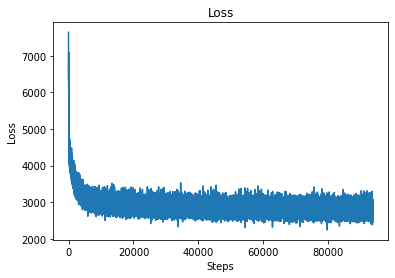

In [21]:
params = {
        'input_dim': 784,
        'layers': [512, 128],
        'latent_dim': 32,
        'hidden_activation': 'relu',
        'dropout': 0.2,
        'batch_norm': True,
        'batch_size': 64,
        'epochs': 100,
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'cuda': True,
        'verbose': True,
        'train': True,
        'save_dir': './vae_model/',
    }
# Initialize the model
model = VAE(params)

model.plot_loss()

In [11]:
# Train the model
model.fit_model(train_loader)
model.plot_loss()

Epoch: 0, Batch: 0, Loss: 7275.3525390625
Epoch: 0, Batch: 300, Loss: 4347.46240234375
Epoch: 0, Batch: 600, Loss: 3986.77099609375
Epoch: 0, Batch: 900, Loss: 3771.2744140625
Epoch: 0, Best Loss: 4532.6650390625
Epoch: 1, Batch: 0, Loss: 4009.625
Epoch: 1, Batch: 300, Loss: 3777.7568359375
Epoch: 1, Batch: 600, Loss: 3705.6171875
Epoch: 1, Batch: 900, Loss: 3765.275634765625
Epoch: 1, Best Loss: 3712.490966796875
Epoch: 2, Batch: 0, Loss: 3815.209228515625
Epoch: 2, Batch: 300, Loss: 3339.89208984375
Epoch: 2, Batch: 600, Loss: 3465.892333984375
Epoch: 2, Batch: 900, Loss: 3264.12744140625
Epoch: 2, Best Loss: 3420.282958984375
Epoch: 3, Batch: 0, Loss: 3149.865234375
Epoch: 3, Batch: 300, Loss: 3505.56982421875
Epoch: 3, Batch: 600, Loss: 3168.721923828125
Epoch: 3, Batch: 900, Loss: 3383.270751953125
Epoch: 3, Best Loss: 3230.718994140625
Epoch: 4, Batch: 0, Loss: 3181.9521484375
Epoch: 4, Batch: 300, Loss: 3102.184326171875
Epoch: 4, Batch: 600, Loss: 3159.85546875
Epoch: 4, Batch:

Loss: 516.2615356445312


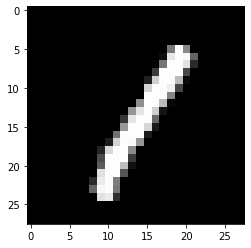

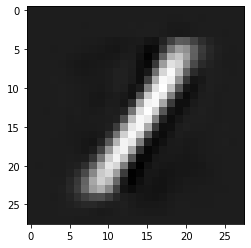

In [29]:
model.eval()
# Choose one image from the dataset
x = train_data[23]
# Change x to format batch
x = x.view(1, -1)
# forward pass
x_hat, mu, log_var = model(x.cuda())
x_hat = x_hat.cpu()
mu = mu.cpu()
log_var = log_var.cpu()
# Compute the loss
loss = model.loss_function(x, x_hat, mu, log_var)
# Print the loss
print('Loss: {}'.format(loss))
# Plot the image
plt.imshow(x.view(28, 28).cpu().numpy(), cmap='gray')
plt.show()
# Plot the reconstruction
plt.imshow(x_hat.detach().numpy().reshape(28, 28), cmap='gray')